In [1]:
from pymongo import MongoClient
import json

#First connect to the database we created.
client = MongoClient()
db = client.tweets 

In [2]:
states_regexs = [r"\w*.\sAL", r"\w*.\sAK", r"\w*.\sAZ", r"\w*.\sAR", r"\w*.\sCA",
               r"\w*.\sCO", r"\w*.\sCT", r"\w*.\sDC", r"\w*.\sDE", r"\w*.\sFL", r"\w*.\sGA", 
          r"\w*.\sHI", r"\w*.\sID", r"\w*.\sIL", r"\w*.\sIN", r"\w*.\sIA", r"\w*.\sKS", r"\w*.\sKY", r"\w*.\sLA", r"\w*.\sME", r"\w*.\sMD", 
          r"\w*.\sMA", r"\w*.\sMI", r"\w*.\sMN", r"\w*.\sMS", r"\w*.\sMO", r"\w*.\sMT", r"\w*.\sNE", r"\w*.\sNV", r"\w*.\sNH", r"\w*.\sNJ", 
          r"\w*.\sNM", r"\w*.\sNY", r"\w*.\sNC", r"\w*.\sND", r"\w*.\sOH", r"\w*.\sOK", r"\w*.\sOR", r"\w*.\sPA", r"\w*.\sRI", r"\w*.\sSC", 
          r"\w*.\sSD", r"\w*.\sTN", r"\w*.\sTX", r"\w*.\sUT", r"\w*.\sVT", r"\w*.\sVA", r"\w*.\sWA", r"\w*.\sWV", r"\w*.\sWI", r"\w*.\sWY"]

In [2]:
states_names = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Washington", "Delaware", "Florida", "Georgia", 
          "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", 
          "Massachusetts", "Michigan", "Minnesota", "Mississippi","Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", 
          "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
          "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

In [ ]:
swing_states = ['Wisconsin', 'Pennsylvania', 'New Hampshire', 'Minnesota', 'Ohio', 'Iowa', 
                'Virginia', 'Florida', 'Michigan', 'Nevada', 'Colorado',  'North Carolina']

In [4]:
import pandas as pd
import time
import re
from nltk.tokenize import RegexpTokenizer
import HTMLParser # In Python 3.4+ import html 
import nltk
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer



from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib
import pickle

def Clean(unescaped_tweet):
        '''This function takes a tweet as input and returns a tokenizing list.'''

        tokenizer = RegexpTokenizer(r'\w+')
        cleaned_tweet_tokens = tokenizer.tokenize(unescaped_tweet.lower())

        return cleaned_tweet_tokens
    
def trump_mention(tweet):
        '''This function takes the text of a tweet and 
            returns true if there is a mention to  Donald Trump or false 
            on the other hand.'''
        if ('trump' in tweet.lower()) or ('donald'  in tweet.lower()):

            return True

        return False
    
def clinton_mention(tweet):
        '''This function takes the text of a tweet and 
            returns true if there is a mention to  Hillary Clinton  or false 
            on the other hand.'''

        if ('hillary' in tweet.lower()) or ('clinton'  in tweet.lower()):

            return True

        return False

def categorize(tr,hil):
        '''This function  categorizes each tweet based
           on text '''

        if tr==hil:

            return 'irrelevant'
        elif tr:
            return 'Trump'
        else:
            return'Clinton'
        
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))



#Imports the classifier
clf = joblib.load('NaiveBayes_CV_1.pkl')
vect = joblib.load('CV_1.pkl') 

stemmer = SnowballStemmer('english')
analyzer = TfidfVectorizer().build_analyzer()


# Preprocessing 

In [5]:
##################################### Starts the iteration
for index, state in enumerate (states_regexs):
    state_search=state
    
    
    
    test = db.tweets.find({'$and':[{'place.country': 'United States'},{'place.full_name': {'$regex': state}}]})
    #summarize = summarize +test.count()
    print ('We have {0} tweets in the {1} state.'.format( test.count(),states_names[index]))
    
    


    start_time = time.time() #Starts time


    tweets = pd.DataFrame()


    state = db.tweets.find({'$and':[{'place.country': 'United States'},{'place.full_name': {'$regex': state_search}}]})
    tweets['text'] = map(lambda tweet: tweet['text'], state)

    state = db.tweets.find({'$and':[{'place.country': 'United States'},{'place.full_name': {'$regex': state_search}}]})
    tweets['lang'] = map(lambda tweet: tweet['lang'],state)


    tweets['text'] = tweets['text'].apply(lambda tweet: re.sub(r"http\S+", "", tweet))

    #########################################################



    tweets['Trump'] = tweets['text'].apply(lambda tweet: trump_mention(tweet))
    tweets['Clinton'] = tweets['text'].apply(lambda tweet: clinton_mention(tweet))
    tweets['Category']=map(lambda tr_col, hil_col: categorize(tr_col, hil_col), tweets['Trump'],tweets['Clinton'])

    ##############################################################

    #tweet mentions --->@
    #tweet hashtags --->#

    #create two column with the the hashtags and the mentions
    tweets['mentions'] = tweets['text'].apply(lambda tweet: re.findall(r'\@\w+',tweet))
    tweets['hashtags'] = tweets['text'].apply(lambda tweet: re.findall(r'\#\w+',tweet))

    #remove hashtags and mentions
    tweets['text'] = tweets['text'].apply(lambda tweet: re.sub(r"\@\w+" , "", tweet))
    tweets['text'] = tweets['text'].apply(lambda tweet: re.sub(r"\#\w+" , "", tweet))

    #remove the numbers from the text
    tweets['text'] =tweets['text'].apply(lambda tweet: ''.join([i for i in tweet if not i.isdigit()]))

    trump_count = 0
    clinton_count =0




    #remove the names and surnames of the two candidates
    tweets['text'] =tweets['text'].apply(lambda tweet: re.sub(r"Trump" , "", tweet))
    tweets['text'] =tweets['text'].apply(lambda tweet: re.sub(r"Clinton" , "", tweet))
    tweets['text'] =tweets['text'].apply(lambda tweet: re.sub(r"Donald" , "", tweet))
    tweets['text'] =tweets['text'].apply(lambda tweet: re.sub(r"Hillary" , "", tweet))
    tweets['text'] =tweets['text'].apply(lambda tweet: re.sub(r"USA" , "", tweet))
    tweets['text'] =tweets['text'].apply(lambda tweet: re.sub(r"amp" , "", tweet))




    #tokenize the text and add an extra column
    tweets['token'] = tweets['text'].apply(lambda tweet: Clean(tweet))

    tweets['token'] = tweets['token'].apply(lambda x: list(set(x)-set(stopwords.words('english'))))

    
    
    
    #Classify the tweets
    X = vect.transform(tweets.text)
    tweets['Sentiment'] =clf.predict(X)
    tweets['Sentiment'] = tweets['Sentiment'].replace(to_replace=0,value='Negative')
    tweets['Sentiment'] = tweets['Sentiment'].replace(to_replace=1,value='Positive')
    
    
    
    
    
    elapsed_time = time.time() - start_time #time ends
    print elapsed_time

    
    
    tweets.to_pickle(str(states_names[ index]))
    

We have 6175 tweets in the Alabama state.
5.47268605232
We have 1030 tweets in the Alaska state.
2.64304113388
We have 14663 tweets in the Arizona state.
9.90133309364
We have 1515 tweets in the Arkansas state.
2.89030694962
We have 67280 tweets in the California state.
38.2836139202
We have 6523 tweets in the Colorado state.
5.53426504135
We have 3987 tweets in the Connecticut state.
4.4434428215
We have 4397 tweets in the Washington state.
4.95803403854
We have 482 tweets in the Delaware state.
2.40125989914
We have 40057 tweets in the Florida state.
23.2558648586
We have 9009 tweets in the Georgia state.
7.88873815536
We have 2541 tweets in the Hawaii state.
3.46768188477
We have 1402 tweets in the Idaho state.
2.86556315422
We have 19635 tweets in the Illinois state.
12.4448800087
We have 4822 tweets in the Indiana state.
4.90201091766
We have 3480 tweets in the Iowa state.
4.81450986862
We have 2358 tweets in the Kansas state.
3.6296710968
We have 3080 tweets in the Kentucky state

# USA States Analysis

In [ ]:
categories = ['Clinton-Positive','Trump-Positive','Clinton-Negative','Trump-Negative','irrelevant-Positive','irrelevant-Negative']

In [5]:
from __future__ import division
SentiDict = {}

pos_map = {}
neg_map = {}

pos_color = {}
neg_color = {}


for name in states_names:    
    
    
    df = pd.read_pickle(name)
    d={}
    group_by_carrier = df.groupby(['Category','Sentiment']).size().reset_index(name="Time")
    for index, row in group_by_carrier.iterrows():

        d['{}-{}'.format(row['Category'], row['Sentiment'])] =  row['Time']
        
    tr_pos = d['Trump-Positive']
    tr_neg = d['Trump-Negative']
    cl_pos = d['Clinton-Positive']
    cl_neg = d['Clinton-Negative']
    
    #normalize the results
    trump_per_pos = d['Trump-Positive']/(d['Trump-Positive']+d['Trump-Negative'])
    clinton_per_pos = d['Clinton-Positive']/(d['Clinton-Positive']+d['Clinton-Negative'])

    
    
    if trump_per_pos>clinton_per_pos:
        #color='red'
        color = 50
    else:
        #color='blue'
        color = 40
        
    d['results_pos'] = color
    
    pos_map[name] = trump_per_pos/clinton_per_pos
    pos_color[name] = color
    
    trump_per_neg = d['Trump-Negative']/(d['Trump-Positive']+d['Trump-Negative'])
    
    clinton_per_neg = d['Clinton-Negative']/(d['Clinton-Positive']+d['Clinton-Negative'])
    
    
    
    
    if trump_per_neg>clinton_per_neg:
        #color='red'
        color = 50
    else:
        #color='blue'
        color = 40
        
    d['results_neg'] = color
    
    
    neg_map[name] = trump_per_neg/clinton_per_neg
    
    neg_color[name] = color
    
    SentiDict[name] = d



# Geographical mapping

In [19]:
%matplotlib inline
import geopandas as  gpd
import warnings
from shapely.geometry.multipolygon import MultiPolygon
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
import pysal as ps
warnings.filterwarnings('ignore')
    
    
def create_map(categories,title):
    
    US = gpd.read_file('US_shape/states.geojson')  #opens the .geojson file as geopandas dataframe
    US.sortlevel
    US.head()



    US['color'] = US.STATE_NAME.apply(lambda x: categories[x])




    a =US.loc[US['STATE_NAME']=="Alaska"].index[0]

    Al = US['geometry'][a]
    Al_ser = gpd.GeoSeries(Al) #Convert to GeoSeries

    Al_scale=Al_ser.scale(xfact=0.5, yfact=0.5,origin='center') #Scales Alaska

    #sc_a=ser.buffer(-0.3)
    Al_scale=Al_scale.translate(xoff=28, yoff=-39) #Moves Alaska down to the right


    b=MultiPolygon(Al_scale.all()) #convert again GeoSeries to a multipolygon
    US['geometry'][a]=b

    h =US.loc[US['STATE_NAME']=="Hawaii"].index[0]

    haw = US['geometry'][h]
    haw_ser = gpd.GeoSeries(haw) #convert to a Geoseries
    haw_ser =haw_ser.scale(xfact=1.8, yfact=1.8,origin='center') #scales Hawaii
    #sc_a=ser.buffer(-0.3)
    haw_ser=haw_ser.translate(xoff=53, yoff=0)

    b2=MultiPolygon(haw_ser.all()) #convert again GeoSeries to a multipolygon
    US['geometry'][h]=b2

    #plots again the map  with Hawaii state increased
    #cmap='seismic'
    #
    #
    
    US.plot(column='color',cmap='seismic', figsize=(15,15),linewidth=1,edgecolor = "black",scheme='fisher_jenks', legend=True)
    #US.plot(column='color',cmap='seismic', figsize=(15,15),linewidth=1,edgecolor = "black",scheme='User_Defined',bins=[0.85, 1, 1.15],legend=True)
    plt.title(title,fontsize=16, fontweight='bold')
    
    plt.axis('off')

In [20]:
import pysal

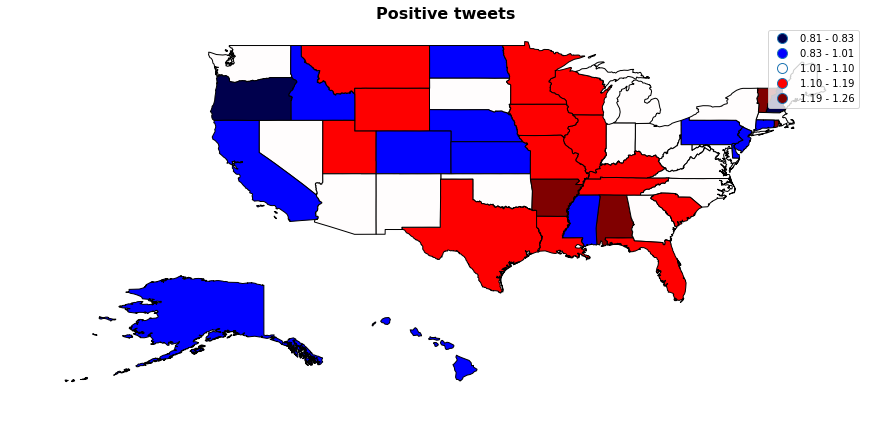

In [21]:
pos_map['District of Columbia']=1.0141059855127716
title='Positive tweets'

create_map(pos_map,title)

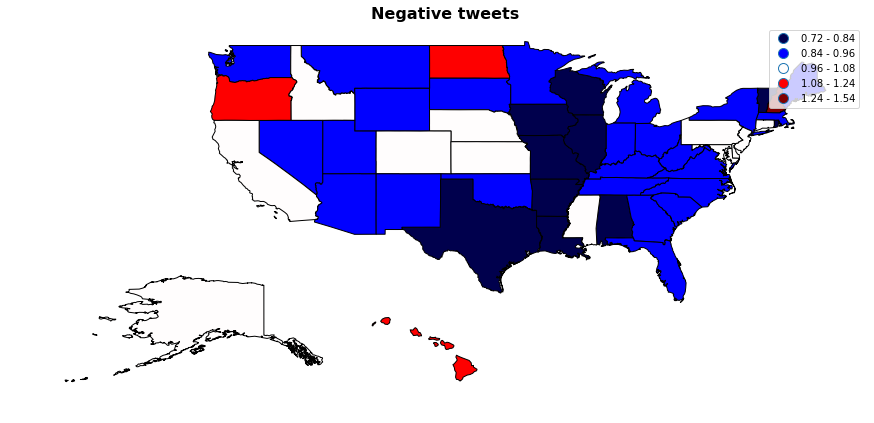

In [119]:


neg_map['District of Columbia']=1.0141059855127716
title='Negative tweets'
create_map(neg_map,title)


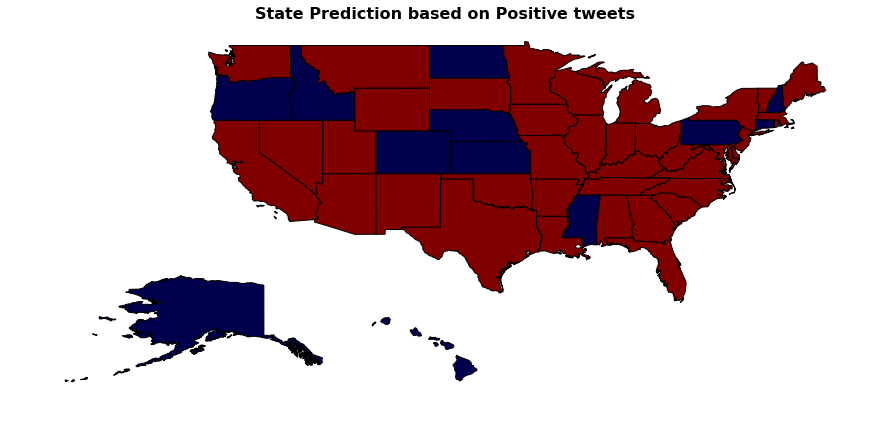

In [156]:
pos_color['District of Columbia']=50
title='State Prediction based on Positive tweets'
create_map(pos_color,title)

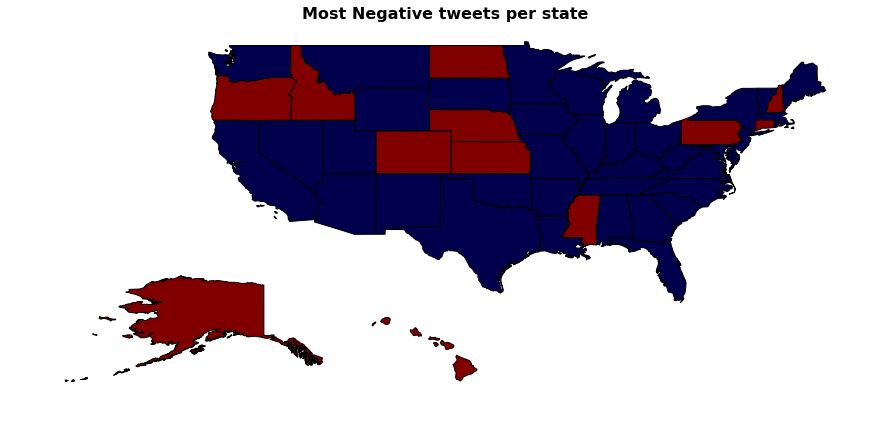

In [157]:
neg_color['District of Columbia']=50
title='Most Negative tweets per state'
create_map(neg_color,title)

# Playground

In [39]:
#Testing pickle open a dataframe
df = pd.read_pickle("California")
#group_by_carrier = df.groupby(['Category','Sentiment']).size().reset_index(name="Time")

print df.shape
df.head()

(67280, 9)


,text,lang,Trump,Clinton,Category,mentions,hashtags,token,Sentiment
0,", you wouldn't recognize a lie if it came from...",en,True,False,Trump,[@realDonaldTrump],[#NeverTrump],"[lie, continually, mouth, came, recognize]",Positive
1,Is yr crazy performance due to dementia or i...,en,True,True,irrelevant,[@realDonaldTrump],[],"[defs, plot, crazy, clever, btwn, due, bring, ...",Negative
2,These Republicans pulling these shenanigans...,en,True,False,Trump,"[@LouDobbs, @realDonaldTrump, @FoxNews]",[],"[shenanigans, party, republicans, pulling, exp...",Negative
3,Change it to what? His usual cheating and frau...,en,True,False,Trump,[],"[#NeverTrump, #BetterWay, #ImWithHer]","[fraud, always, lies, cheating, usual, con, ch...",Positive
4,and are the founders &; MVP of,en,False,True,Clinton,[],"[#Obama, #CrookedHillary, #ISIS]","[mvp, founders]",Positive


In [40]:
group_by_carrier = df.groupby(['Category','Sentiment']).size().reset_index(name="Counts")

group_by_carrier

,Category,Sentiment,Counts
0,Clinton,Negative,6006
1,Clinton,Positive,7535
2,Trump,Negative,16009
3,Trump,Positive,20575
4,irrelevant,Negative,6965
5,irrelevant,Positive,10190


In [41]:
d={}

for index, row in group_by_carrier.iterrows():
    print row['Counts']
    d['{}-{}'.format(row['Category'], row['Sentiment'])] =  row['Counts']
    
print d

6006
7535
16009
20575
6965
10190
{'Clinton-Positive': 7535, 'Trump-Positive': 20575, 'Clinton-Negative': 6006, 'Trump-Negative': 16009, 'irrelevant-Positive': 10190, 'irrelevant-Negative': 6965}


In [20]:
d2={}
d2["Wyoming"] = d

print d2

{'Wyoming': {'Clinton-Positive': 59, 'Trump-Positive': 105, 'Clinton-Negative': 51, 'Trump-Negative': 71, 'irrelevant-Positive': 30, 'irrelevant-Negative': 42}}


In [22]:
d2["Wyoming"]

{'Clinton-Negative': 51,
 'Clinton-Positive': 59,
 'Trump-Negative': 71,
 'Trump-Positive': 105,
 'irrelevant-Negative': 42,
 'irrelevant-Positive': 30}